In [ ]:
# ==========================================
# CELL 1: CÀI ĐẶT THƯ VIỆN
# ==========================================
%pip install pyvi scikit-learn pandas matplotlib seaborn -q
print("Đã cài đặt xong thư viện!")

In [ ]:
# ==========================================
# CELL 2: MOUNT DRIVE & CẤU HÌNH PATH
# ==========================================
import os
import pandas as pd
import numpy as np
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# Đường dẫn GitHub Raw
TRAIN_PATH = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/train.csv'
DEV_PATH   = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/dev.csv'
TEST_PATH  = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/test.csv'
AUG_PATH   = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/train_augmented.csv'

In [ ]:
# ==========================================
# CELL 3: ĐỌC DỮ LIỆU & TIỀN XỬ LÝ
# ==========================================
print("Đang đọc và xử lý dữ liệu...")
train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(DEV_PATH)
test_df  = pd.read_csv(TEST_PATH)
aug_df   = pd.read_csv(AUG_PATH)

# Chuẩn hóa nhãn
for df in [train_df, val_df, test_df, aug_df]:
    if 'Label' in df.columns:
        df.rename(columns={'Label': 'label'}, inplace=True)

# Gộp data augmented
train_df = pd.concat([train_df, aug_df], ignore_index=True).sample(frac=1, random_state=42)

def preprocess_for_nb(df):

    texts = []
    for _, row in df.iterrows():
        p = ViTokenizer.tokenize(str(row['Premise']))
        h = ViTokenizer.tokenize(str(row['Hypothesis']))
        combined = f"{p} [SEP] {h}" # Dùng SEP để mô hình phân biệt 2 phần
        texts.append(combined)
    return texts

X_train = preprocess_for_nb(train_df)
y_train = train_df['label'].values

X_val = preprocess_for_nb(val_df)
y_val = val_df['label'].values

X_test = preprocess_for_nb(test_df)
y_test = test_df['label'].values

In [ ]:
# ==========================================\
# CELL: TÌM THAM SỐ TỐI ƯU
# ==========================================\
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import time

print("--- ĐANG CHUẨN BỊ DỮ LIỆU ĐỂ GRID SEARCH ---")

X_full_list = X_train + X_val
y_full_label = np.concatenate([y_train, y_val])

# 2. Tạo chỉ mục PredefinedSplit (-1: Train, 0: Dev)
split_index = [-1] * len(X_train) + [0] * len(X_val)
pds = PredefinedSplit(test_fold=split_index)

# 3. Thiết lập Pipeline
pipeline_grid = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# 4. Thiết lập không gian tìm kiếm (Thêm ngram_range)
param_grid = {
    # Quét N-gram:

    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],

    'tfidf__max_features': [500, 1000, 3000, 5000, 10000, None],

    # Alpha của Naive Bayes
    'nb__alpha': [0.01, 0.1, 0.5, 1.0]
}

print(f"Đang chạy ...")
start = time.time()

grid_nb = GridSearchCV(
    pipeline_grid,
    param_grid,
    cv=pds,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_nb.fit(X_full_list, y_full_label)

print(f"\nTổng thời gian: {time.time() - start:.2f}s")
print("-" * 50)
print(f"CẤU HÌNH TỐI ƯU NHẤT: {grid_nb.best_params_}")
print(f"ĐIỂM SỐ CAO NHẤT (DEV): {grid_nb.best_score_:.4f}")
print("-" * 50)

# --- PHÂN TÍCH KẾT QUẢ ---
results_df = pd.DataFrame(grid_nb.cv_results_)
# Chọn các cột quan trọng để hiển thị
cols = ['param_tfidf__ngram_range', 'param_nb__alpha', 'param_tfidf__max_features', 'mean_test_score']

print("\nTOP 5 CẤU HÌNH TỐT NHẤT:")
# Sắp xếp giảm dần theo điểm số
print(results_df[cols].sort_values(by='mean_test_score', ascending=False).head(5))

# --- SO SÁNH HIỆU QUẢ CỦA N-GRAM ---
print("\n--- SO SÁNH TRUNG BÌNH THEO N-GRAM ---")
# Gom nhóm để xem trung bình N-gram nào tốt nhất
print(results_df.groupby('param_tfidf__ngram_range')['mean_test_score'].max())

### Naive Bayes Validation Results
- Best F1-score : **0.4603**

**Best hyperparameters (GridSearchCV):**
```python
{
  'nb__alpha': 0.01,
  'tfidf__max_features': 10000,
  'tfidf__ngram_range': (1, 2)
}


--- BẮT ĐẦU HUẤN LUYỆN VỚI BEST PARAMS ---
--- HUẤN LUYỆN KẾT THÚC ---

--- KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST ---
                   precision    recall  f1-score   support

   Entailment (0)     0.4000    0.2286    0.2909        70
Contradiction (1)     0.4595    0.4722    0.4658        72
      Neutral (2)     0.3939    0.5493    0.4588        71

         accuracy                         0.4178       213
        macro avg     0.4178    0.4167    0.4052       213
     weighted avg     0.4181    0.4178    0.4060       213



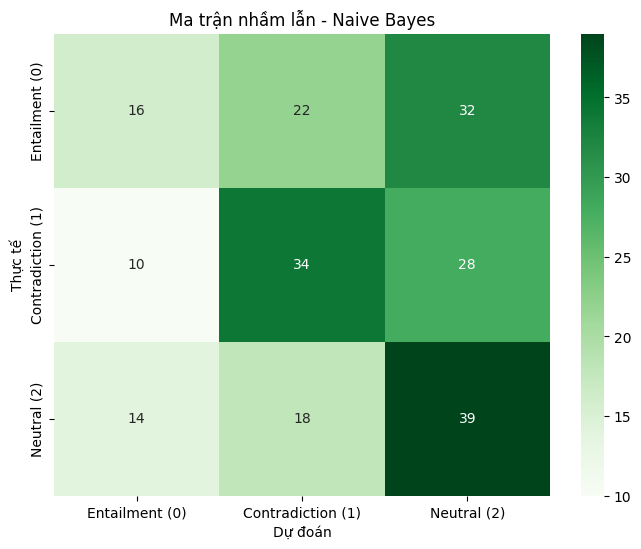

In [7]:
# ==========================================\
# CELL 4: HUẤN LUYỆN MODEL VỚI THAM SỐ TỐT NHẤT
# ==========================================\
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

print("--- BẮT ĐẦU HUẤN LUYỆN VỚI BEST PARAMS ---")


best_ngram = (1, 2)
best_features = 10000
best_alpha = 0.01

# 2. GỘP TRAIN + DEV

X_final_train = X_train + X_val
y_final_train = np.concatenate([y_train, y_val])

# 3. KHỞI TẠO PIPELINE VỚI THAM SỐ ĐÃ CHỌN
final_model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=best_ngram, max_features=best_features)),
    ('nb', MultinomialNB(alpha=best_alpha))
])

# 4. HUẤN LUYỆN
final_model.fit(X_final_train, y_final_train)
print("--- HUẤN LUYỆN KẾT THÚC ---")

# ==========================================\
# CELL 5: ĐÁNH GIÁ TRÊN TẬP TEST
# ==========================================\
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = final_model.predict(X_test)
target_names = ['Entailment (0)', 'Contradiction (1)', 'Neutral (2)']

print("\n--- KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST ---")
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# Vẽ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title(f'Ma trận nhầm lẫn - Naive Bayes')
plt.show()